# Rank Features
On this notebook we'll use different plots and techniques to rank features given their statistical importance.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load the cleaned data
user_data_df = pd.read_csv('./user_data_cleaned.csv', index_col=0)

# split the dataset to make sure we don't peek into test data
train = user_data_df[
    (user_data_df['airing_start_date'] >= '2014-01-01') & (user_data_df['airing_start_date'] < '2017-01-01')
]

## 1D Rank

<IPython.core.display.Javascript object>


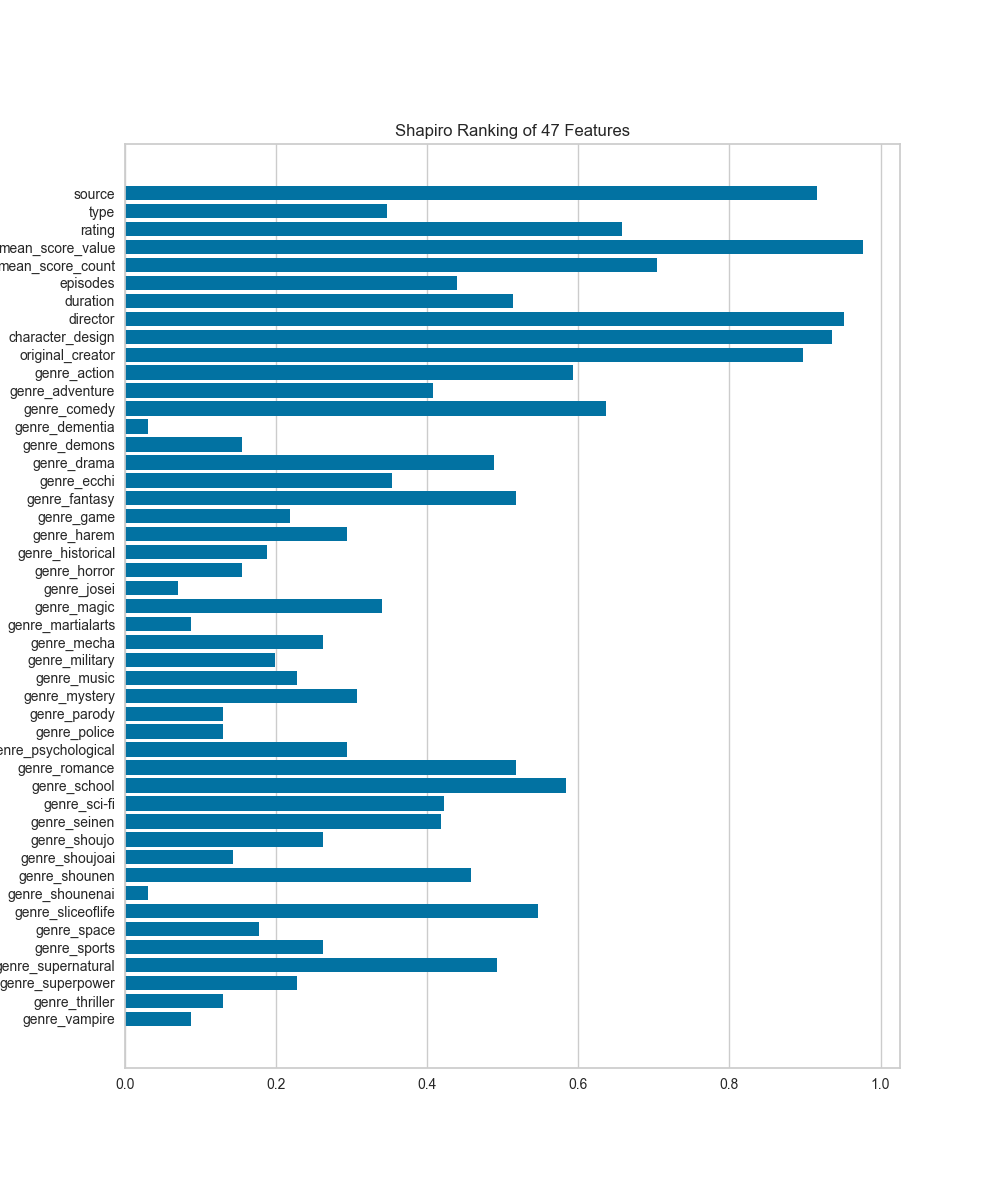

In [3]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, Imputer
from yellowbrick.features import Rank1D
import matplotlib.pyplot as plt
%matplotlib notebook

# prepare a bigger ax for the visualization
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)

# only leave completed and dropped
rank_df = train.copy()

# label encoding
label_encoder = LabelEncoder()
rank_df['source'] = label_encoder.fit_transform(rank_df.source.fillna(''))
rank_df['type'] = label_encoder.fit_transform(rank_df.type.fillna(''))
rank_df['rating'] = label_encoder.fit_transform(rank_df.rating.fillna(''))
rank_df['director'] = label_encoder.fit_transform(rank_df.director.fillna(''))
rank_df['character_design'] = label_encoder.fit_transform(rank_df.character_design.fillna(''))
rank_df['original_creator'] = label_encoder.fit_transform(rank_df.original_creator.fillna(''))

# missing values
imputer = Imputer()
rank_df['mean_score_value'] = imputer.fit_transform(rank_df.mean_score_value.values.reshape(-1, 1))
rank_df['mean_score_count'] = imputer.fit_transform(rank_df.mean_score_count.values.reshape(-1, 1))
rank_df['episodes'] = imputer.fit_transform(rank_df.episodes.values.reshape(-1, 1))
rank_df['duration'] = imputer.fit_transform(rank_df.duration.values.reshape(-1, 1))

# multilabel binarizing
multilabel_binarizer = MultiLabelBinarizer()
genres = multilabel_binarizer.fit_transform(
    rank_df.genres.apply(
        lambda genres: list(map(lambda genre: 'genre_{}'.format(genre), genres.split(',')))
            if type(genres) is str 
            else []
    )
)

genre_names = multilabel_binarizer.classes_.tolist()

for i, genre in enumerate(genre_names):
    rank_df[genre] = genres[:, i]
    
# Specify the features of interest
features = [
    'source', 'type', 'rating', 'mean_score_value', 'mean_score_count', 'episodes', 'duration',
    'director',  'character_design', 'original_creator',
] + genre_names

# Extract the numpy arrays from the data frame
X = rank_df[features].values

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(features=features, ax=ax)

visualizer.fit(X)
visualizer.transform(X)

visualizer.poof()

### Conclusions
From the simple features (source, type, rating, mean_score_value, mean_score_count, episodes and duration) all seem to be somehow statistically significative except the episodes count.

Regarding the staff related features (director, character_design, original_creator) they seem to be significative, but further analysis makes it obvious that the unique values are a lot, making them really bad for generalization.

As for the genre, we can see that a bunch of them are pretty siginifactive which makes me believe they can be very good estimators.

Finally, also tried multi label binarization with other features (studios, main_vas) which have way too many different unique values, making them not very significative in this analysis. Note: after thinking for a bit, this could be useful if we binarize them somehow.

## 2D rank 

<IPython.core.display.Javascript object>


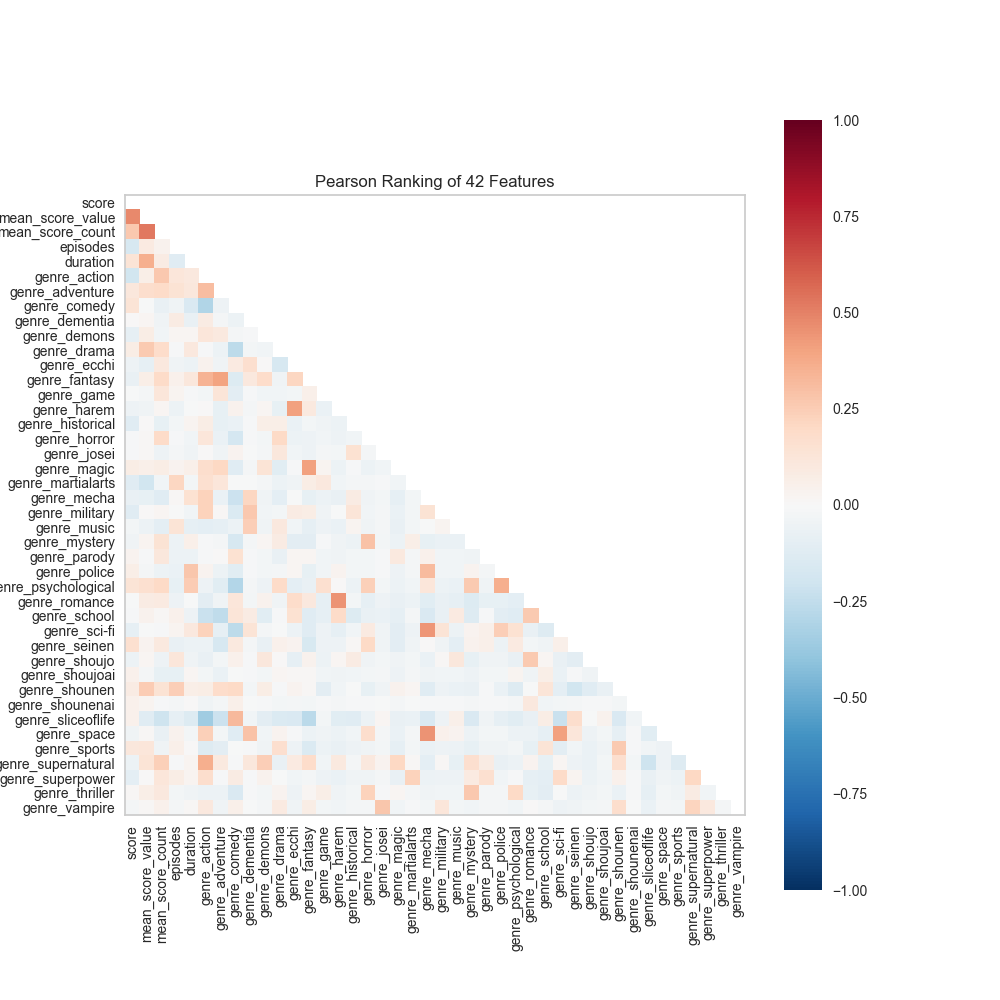

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer, Imputer
from yellowbrick.features import Rank2D
import matplotlib.pyplot as plt
%matplotlib notebook

# only leave completed and dropped
rank2_df = train[
    (train.user_status == 'Completed') |  (train.user_status == 'Dropped')
].copy()

# missing values
imputer = Imputer()
rank2_df['mean_score_value'] = imputer.fit_transform(rank2_df.mean_score_value.values.reshape(-1, 1))
rank2_df['mean_score_count'] = imputer.fit_transform(rank2_df.mean_score_count.values.reshape(-1, 1))
rank2_df['episodes'] = imputer.fit_transform(rank2_df.episodes.values.reshape(-1, 1))
rank2_df['duration'] = imputer.fit_transform(rank2_df.duration.values.reshape(-1, 1))
rank2_df['score'] = imputer.fit_transform(rank2_df.score.values.reshape(-1, 1))

# multilabel binarizing
multilabel_binarizer = MultiLabelBinarizer()
genres = multilabel_binarizer.fit_transform(
    rank2_df.genres.apply(
        lambda genres: list(map(lambda genre: 'genre_{}'.format(genre), genres.split(',')))
            if type(genres) is str 
            else []
    )
)

genre_names = multilabel_binarizer.classes_.tolist()

for i, genre in enumerate(genre_names):
    rank2_df[genre] = genres[:, i]

# Specify the features of interest
features = ['score', 'mean_score_value', 'mean_score_count', 'episodes', 'duration'] + genre_names

# Extract the numpy arrays from the data frame
X = rank2_df[features].values

# prepare a bigger ax for the visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Instantiate the 2d visualizer with covariance
visualizer = Rank2D(features=features, ax=ax, algorithm='pearson')
visualizer.fit(X)
visualizer.transform(X)
visualizer.poof()

### Conclusions
Not much to say about this one; it only shows some trends within the data (more people watch certain genres, some genres have longer series) but not much from where we can infer data or try to create/discard features.

## Select K Best

In [5]:
import sys
sys.path.append('/mnt/data/workspace/machine-learning/src')
from util.transformers import Raiser, StringSplitter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MultiLabelBinarizer, Imputer, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper, CategoricalImputer, gen_features 
    
kbest_df = train[
    (train.user_status == 'Completed') |  (train.user_status == 'Dropped')
].copy()

# map features
feature_mapper = DataFrameMapper(
    gen_features(
        columns=[['mean_score_value'], ['mean_score_count'], ['episodes'], ['duration']],
        classes=[{'class': Imputer}]
    ) + gen_features(
        columns=['source', 'type', 'rating'],
        classes=[{'class': CategoricalImputer}, {'class': LabelEncoder}, {'class': Raiser}, {'class': OneHotEncoder}]
    ) + gen_features(
        columns=['genres', 'studios'],
        classes=[{'class': StringSplitter}, {'class': MultiLabelBinarizer}]
    ) + [
        ('score', None)
    ],
    df_out=True 
)

kbest_df = feature_mapper.fit_transform(kbest_df)

# do a selecet k best for the score
y = kbest_df.score
X = kbest_df.drop('score', axis=1)

kbest_selector = SelectKBest(chi2, 'all')
chi2_scores = kbest_selector.fit_transform(X, y)

for column, score in sorted(zip(X.columns, chi2_scores), key=lambda x: x[1][0], reverse=True):
    print('{:10.2f} {}'.format(score[0], column))

      8.99 studios_kinemacitrus
      8.87 studios_khara
      8.65 studios_j.c.staff
      8.63 studios_productioni.g
      8.56 genres_demons
      8.56 studios_productionreed
      8.52 studios_studiomoriken
      8.47 rating_pg-13-teens13orolder
      8.44 genres_drama
      8.43 mean_score_value
      8.42 genres_sci-fi
      8.40 genres_thriller
      8.34 genres_supernatural
      8.33 studios_tnk
      8.29 studios_manglobe
      8.27 genres_romance
      8.27 studios_shuka
      8.24 studios_productionims
      8.23 genres_superpower
      8.22 type_movie
      8.19 source_game
      8.16 type_tv
      8.16 studios_tatsunokoproduction
      8.15 studios_bones
      8.13 source_cardgame
      8.13 studios_whitefox
      8.12 genres_sports
      8.11 genres_shounenai
      8.09 genres_sliceoflife
      8.04 studios_fujitv
      8.04 studios_gainax
      8.02 studios_madhouse
      7.96 studios_witstudio
      7.95 studios_dongwooa&e
      7.94 type_special
      7.92 source_book